This notebook gets the results for the evaluation from the comet machine learning api and plot them.
All the plots of BERT scores as a function of the group size.

In [21]:
from typing import List, Dict
from IPython.display import display, Markdown

from comet_ml import API, APIExperiment
import matplotlib.pyplot as plt

In [22]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from evaluation.helpers import get_comet_api_key

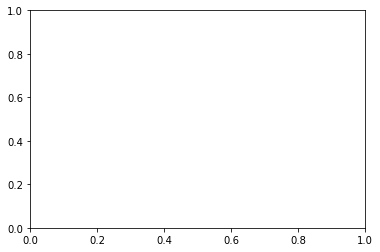

In [23]:
api = API(api_key=get_comet_api_key())

plt.autoscale(False)

stat_names = (
    "mean",
    "median",
    "75_percentile",
    "25_percentile",
    "min",
    "max",
    "standard_deviation",
)

metric_names = (
    "BERT_f1", "BERT_precision", "BERT_recall",
)

USERNAME: str = "yonikremer"
PROJECT_NAME: str = "grouped-sampling-evaluation"
EXPERIMENTS: List[APIExperiment] = api.get_experiments(
    workspace=USERNAME,
    project_name=PROJECT_NAME,
    pattern=None
)

X_LABEL = "group size"

In [28]:
def get_parameter(experiment: APIExperiment, parameter_name: str):
    """Gets a parameter from an APIExperiment."""
    summary: List[dict] = experiment.get_parameters_summary()
    for curr_param in summary:
        if curr_param["name"] == parameter_name:
            return curr_param["valueCurrent"]
    raise RuntimeError(f"no parameter in {summary} with name {parameter_name}")


def get_group_size(experiment: APIExperiment) -> int:
    """Gets the group size from an APIExperiment."""
    return int(get_parameter(experiment, "group_size"))


def get_score_stat(experiment: APIExperiment, stat: str) -> Dict[str, float]:
    score_stat = {}
    for curr_metric_name in metric_names:
        summary: List[dict] = experiment.get_metrics_summary()
        for curr_metric_value in filter(lambda x: x["name"] == f"general_{curr_metric_name}_{stat}", summary):
            score_stat[curr_metric_name] = float(curr_metric_value["valueCurrent"])
    return score_stat


def plot_data(data: Dict[int, Dict[str, float]], stat: str) -> None:
    """Adds a scatter plot to the panel.
    makes sure that:
    the y scale is from 0 to 1
    the graph is added to the panel using ui.display_figure
    data format:
    {group_size: {metric_name: score}}
    """
    curr_figure = plt.gcf()
    curr_figure.clear()
    colors = ["red", "green", "blue"]
    for curr_metric_name, curr_color in zip(metric_names, colors):
        plt.scatter(
            data.keys(),
            [data[curr_group_size][curr_metric_name] for curr_group_size in data.keys()],
            color=curr_color,
            label=curr_metric_name,
        )
    plt.legend()
    plt.xlabel(X_LABEL)
    y_label = f"BERT scores {stat}"
    plt.ylabel(y_label)
    plt.title(f"{y_label} as a function of {X_LABEL}")
    plt.ylim(0, 1)
    plt.show()
    plt.clf()


def generate_plot(stat_name: str) -> None:
    display(Markdown(f"## {stat_name}"))
    group_size_to_score_stats: Dict[int, Dict[str, float]] = {}
    for exp in EXPERIMENTS:
        group_size: int = get_group_size(exp)
        curr_exp_stats: Dict[str, float] = get_score_stat(exp, stat_name)
        if len(curr_exp_stats) > 0:
            group_size_to_score_stats[group_size] = curr_exp_stats
    if len(group_size_to_score_stats) > 0:
        plot_data(group_size_to_score_stats, stat_name)
    else:
        display(Markdown("No experiments with this stat"))

# BERT Scores as a function of group size

## mean

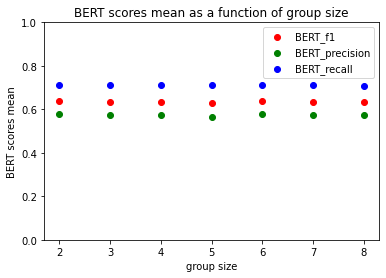

## median

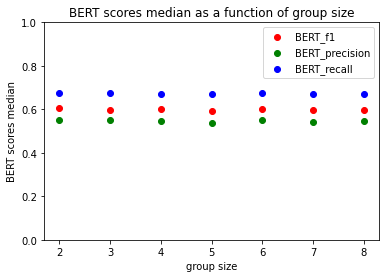

## 75_percentile

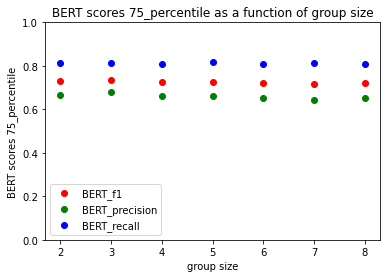

## 25_percentile

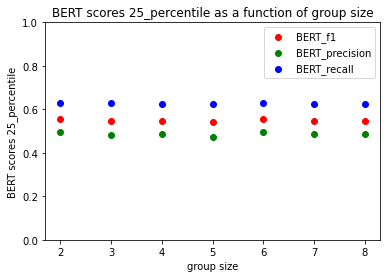

## min

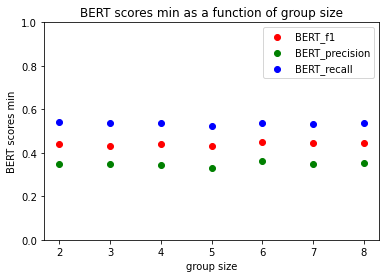

## max

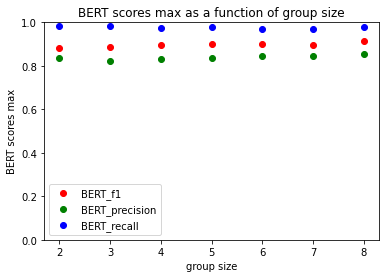

## standard_deviation

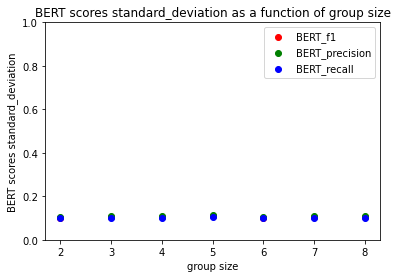

<Figure size 432x288 with 0 Axes>

In [29]:
display(Markdown(f"# BERT Scores as a function of {X_LABEL}"))
for stat in stat_names:
    generate_plot(stat)